In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from feature_engine.imputation import CategoricalImputer, DropMissingData
from feature_engine.encoding import RareLabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from feature_engine.wrappers import SklearnTransformerWrapper
from catboost import CatBoostClassifier
import optuna
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback
import xgboost as xgb
import shap 
import pickle
import random 
import warnings

warnings.filterwarnings(action='ignore')

### Load Data

In [85]:
with open('models/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('models/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('models/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('models/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)


# get columns 
columns = X_train.columns
cat_cols = X_train.iloc[:,[1, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]].columns


In [86]:
X_train.head(1)

,amount_tsh,funder,gps_height,installer,basin,region,population,public_meeting,scheme_management,permit,extraction_type_class,management_group,payment_type,quality_group,quantity_group,source_class,waterpoint_type_group,age
5974,0.0,Government Of Tanzania,1410,DWE,Pangani,Arusha,200,True,VWC,True,gravity,user-group,unknown,good,enough,groundwater,communal standpipe,43.284932


### Load Models

In [87]:
with open('models/xgb_preprocessing.pkl', 'rb') as f:
    pipeline_xgb = pickle.load(f)

with open('models/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [88]:
pipeline_xgb

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_transformer',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [1, 3, 4, 5, 7, 8, 9, 10, 11,
                                                   12, 13, 14, 15, 16]),
                                                 ('num_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 2, 6, 17])]))])

In [89]:
xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.670726369939647, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.65297307591977, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18903976053222393,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [91]:
column_names = pipeline_xgb.named_steps['preprocessing'].named_transformers_['cat_transformer']['onehot']
column_names.get_feature_names_out(cat_cols)


array(['funder_0', 'funder_A/co Germany', 'funder_Aar', ...,
       'waterpoint_type_group_hand pump',
       'waterpoint_type_group_improved spring',
       'waterpoint_type_group_other'], dtype=object)

### 

In [92]:
# preprocess data
X_train = pipeline_xgb.fit_transform(X_train)
X_test = pipeline_xgb.transform(X_test)

In [93]:
X_train[:1000]

<1000x3505 sparse matrix of type '<class 'numpy.float64'>'
	with 18000 stored elements in Compressed Sparse Row format>

### Explain the XGBoost Classifier

In [7]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.670726369939647, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0.65297307591977, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18903976053222393,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=250, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

In [8]:
y_pred = xgb_model.predict(X_test)


In [9]:
def confusion_matrix_eval(y_test, y_pred):
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print("-"*90)
    print("[CLASS_REPORT] printing classification report to console")
    print("-"*90)
    print(cr)
    print("-"*90)
    return [cm, cr]

In [10]:
cm = confusion_matrix_eval(y_test=y_test, y_pred=y_pred)

------------------------------------------------------------------------------------------
[CLASS_REPORT] printing classification report to console
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      9678
           1       0.56      0.31      0.40      1295
           2       0.84      0.75      0.79      6847

    accuracy                           0.80     17820
   macro avg       0.73      0.65      0.68     17820
weighted avg       0.79      0.80      0.79     17820

------------------------------------------------------------------------------------------


### Get Shapley Values

In [11]:
# fit explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

[array([[-5.9357069e-05,  2.9608031e-05,  0.0000000e+00, ...,
         1.4651132e-01,  3.2525819e-03,  6.0247254e-02],
       [ 4.9014310e-05,  2.9612947e-05,  0.0000000e+00, ...,
        -8.9988790e-02,  8.7823868e-02, -6.2199898e-02],
       [-3.2812277e-05,  2.9612947e-05,  0.0000000e+00, ...,
        -8.4440798e-02,  5.9282400e-02,  3.2148641e-02],
       ...,
       [-4.8396405e-06,  2.9608031e-05,  0.0000000e+00, ...,
        -1.6467108e-01, -1.1303465e-01, -1.4361815e-01],
       [ 1.3211946e-04,  2.9612947e-05,  0.0000000e+00, ...,
        -1.6031396e-01,  5.3439647e-02,  2.0295598e-01],
       [ 1.3413078e-04,  2.9612947e-05,  0.0000000e+00, ...,
        -1.9617103e-01,  2.0680064e-02,  1.1120771e-01]], dtype=float32), array([[ 1.10887340e-03,  0.00000000e+00, -4.39141382e-04, ...,
        -7.96620771e-02, -9.21064839e-02, -3.59856158e-01],
       [ 8.52687401e-04,  0.00000000e+00, -4.16899187e-04, ...,
         1.71863027e-02,  1.63847908e-01,  1.93983227e-01],
       [ 8.351

TypeError: 'OneHotEncoder' object is not subscriptable

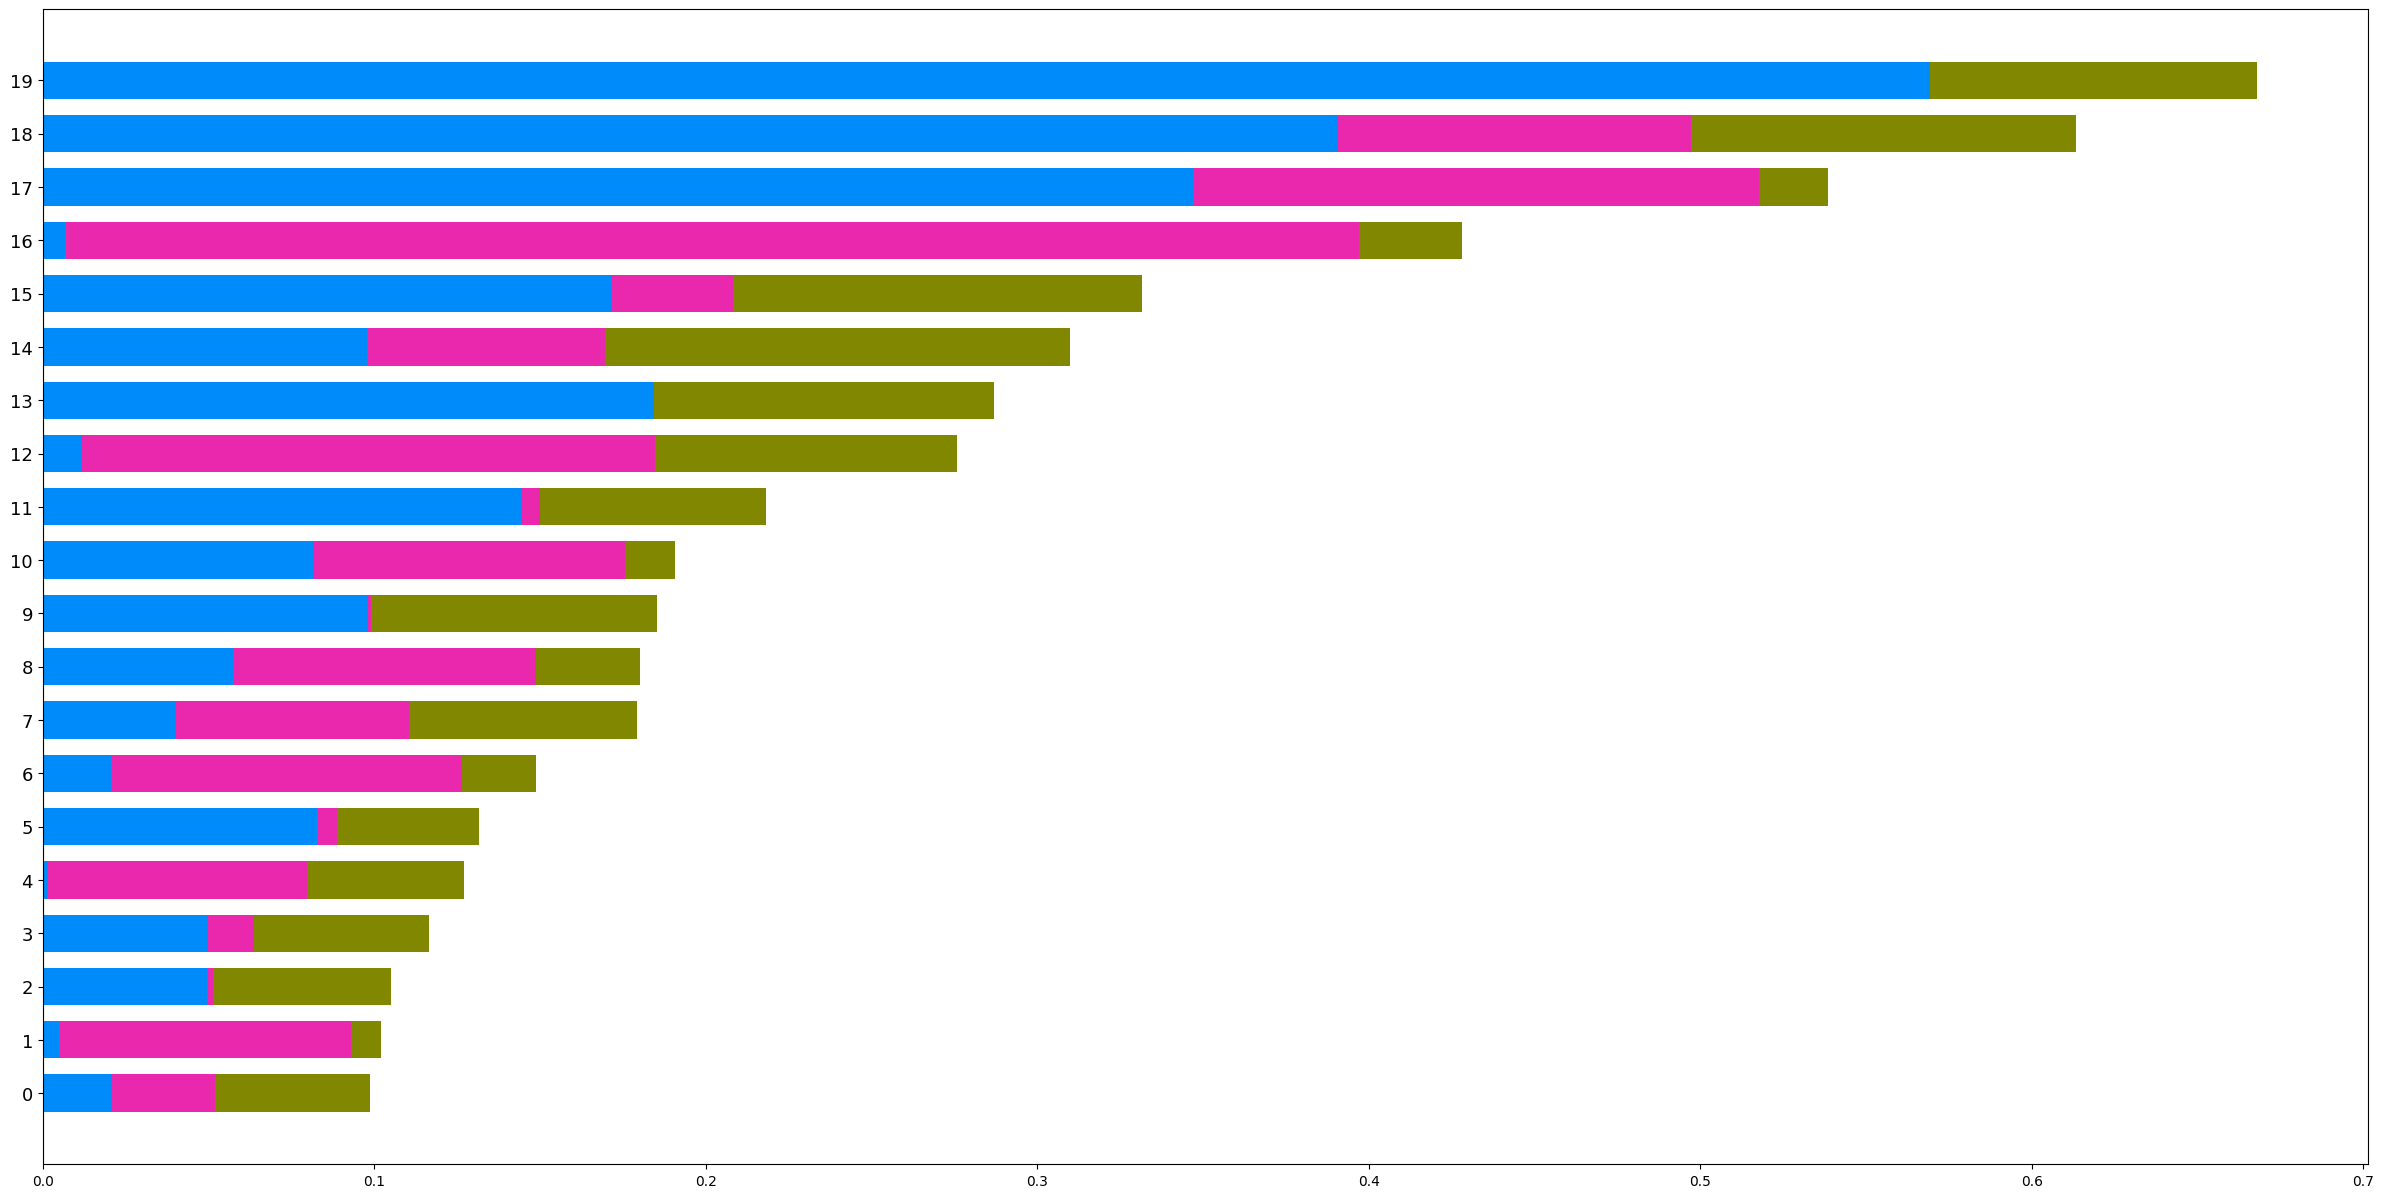

In [94]:

# create summary plot
plt_shap = shap.summary_plot(shap_values, #Use Shap values array
                             features=X_train[:1000], # Use training set features
                             feature_names=column_names, #Use column names
                             show=False, #Set to false to output to folder
                             plot_size=(30,15)) # Change plot size
# Save my figure to a directory
plt.savefig("plots/global_shap.png")

In [25]:
X_train

<41580x3505 sparse matrix of type '<class 'numpy.float64'>'
	with 748440 stored elements in Compressed Sparse Row format>